# Bring Your Own Data

In [18]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import evaluation.metrics as m
import evaluation.eval_framework as evu
import pandas as pd
import math

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

## Required fields
- `power_rate`: float in kWh or MWh
- `session_start_time`: datetime64[ns] '2023-06-07 16:19:10'
- `end_start_time`: datetime64[ns] '2023-06-07 20:30:10'

## Derived Fields
- `time_needed`: int
- `total_intervals`: int

### Notes

- The example below assumes that the user / device is expressing total charge needed as a time. For example, if I need 40 kW of power to fully charge my device, and my power output rate is 10 kWh, then I need (40/10) * 60 minutes of charge.
- evu.convert_to_utc() to convert a time expressed in any local time to UTC
- evu.intervalize_power_rate() to convert a power rate from kilowatts to a 5-minute interval rate, optionally in megawatts
- Use the sanitize functions to convert float to int

In [19]:
def sanitize_time_needed(x):
    return int(x / 300.0) * 5

def sanitize_total_intervals(x):
    return math.ceil(x)

In [20]:
example_df = pd.DataFrame([['2023-01-03 03:17:26',
        '2023-01-03 09:32:52.456704',
        326.4],
       ['2023-01-04 06:20:50',
        '2023-01-04 13:28:55.231872',
        326.4],
       ['2023-01-13 11:05:16',
        '2023-01-13 18:08:20.434752',
        326.4],
       ['2023-01-14 13:56:37',
        '2023-01-14 22:01:04.455693',
        326.4],
       ['2023-01-19 07:52:55',
        '2023-01-19 16:51:48.332139',
        326.4]],
        columns = ["session_start_time","session_end_time","power_rate"]
)

example_df["session_start_time"] = pd.to_datetime(example_df["session_start_time"])
example_df["session_end_time"] = pd.to_datetime(example_df["session_end_time"])

In [21]:
example_df

,session_start_time,session_end_time,power_rate
0,2023-01-03 03:17:26,2023-01-03 09:32:52.456704,326.4
1,2023-01-04 06:20:50,2023-01-04 13:28:55.231872,326.4
2,2023-01-13 11:05:16,2023-01-13 18:08:20.434752,326.4
3,2023-01-14 13:56:37,2023-01-14 22:01:04.455693,326.4
4,2023-01-19 07:52:55,2023-01-19 16:51:48.332139,326.4


In [22]:
example_df["length_of_session_in_seconds"] = (
        example_df.session_end_time - example_df.session_start_time
    ) / pd.Timedelta(seconds=1)

example_df["total_intervals"] = example_df["length_of_session_in_seconds"] / 300
example_df["total_intervals"] = example_df["total_intervals"].apply(lambda x: sanitize_total_intervals(x))
example_df["time_needed"] = example_df["length_of_session_in_seconds"].apply(lambda x: sanitize_time_needed(x))

example_df["power_rate"] = example_df["power_rate"].apply(lambda x: evu.intervalize_power_rate(x,convert_to_MW = True))

In [23]:
example_df

,session_start_time,session_end_time,power_rate,length_of_session_in_seconds,total_intervals,time_needed
0,2023-01-03 03:17:26,2023-01-03 09:32:52.456704,0.0272,22526.456704,76,375
1,2023-01-04 06:20:50,2023-01-04 13:28:55.231872,0.0272,25685.231872,86,425
2,2023-01-13 11:05:16,2023-01-13 18:08:20.434752,0.0272,25384.434752,85,420
3,2023-01-14 13:56:37,2023-01-14 22:01:04.455693,0.0272,29067.455693,97,480
4,2023-01-19 07:52:55,2023-01-19 16:51:48.332139,0.0272,32333.332139,108,535


In [24]:
# Required fields are time_needed, total_intervals, power_rate, and session_start_time
FILE_PATH = ''
REGION = 'PJM_DC' # i.e. PJM_DC

In [25]:
#df = pd.read_csv(FILE_PATH)
df = example_df

In [26]:
df["moer_forecast"] = df.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, 
        x.total_intervals,
        region=REGION
    ),
    axis=1,
)

df["moer_actual"] = df.apply(
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, 
        x.total_intervals,
        region=REGION
    ),
    axis=1,
)

<Axes: xlabel='point_time'>

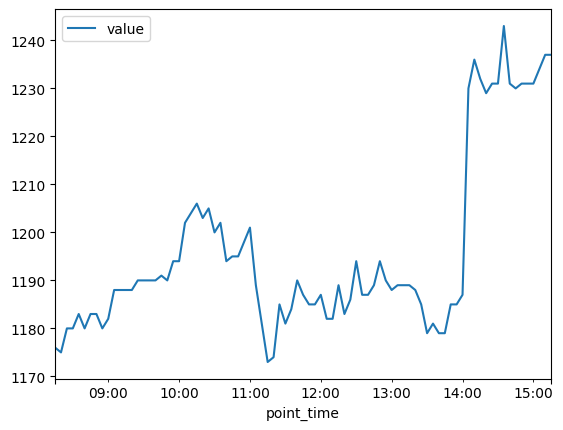

In [27]:
df.iloc[0]["moer_actual"].set_index("point_time").plot(kind="line")

<Axes: xlabel='point_time'>

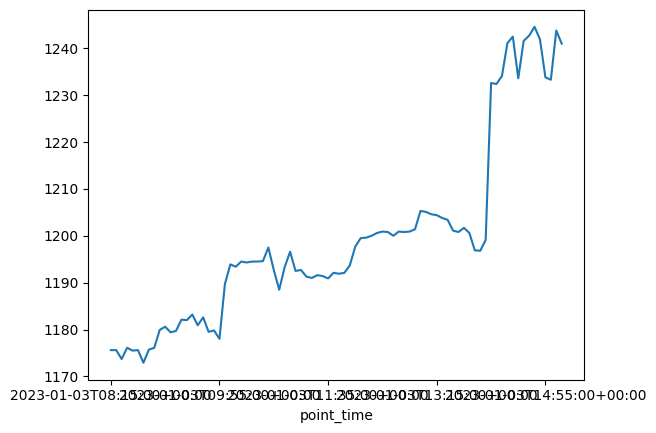

In [28]:
df.iloc[0]["moer_forecast"].set_index("point_time")["value"].plot(kind="line")

In [38]:
get_charging_schedule = lambda x: x["usage"].values.flatten()
get_total_emissions = lambda x: x["emissions_co2e_lb"].sum()

# Function to apply optimization
def apply_optimization(row, moer_data, optimization_method, power_rate_col = "power_rate", time_needed_col="time_needed", total_intervals_col="total_intervals"):
    return evu.get_schedule_and_cost_api(
        usage_power_kw=row[power_rate_col],
        time_needed=row[time_needed_col],
        total_time_horizon=row[total_intervals_col],
        moer_data=moer_data,
        optimization_method=optimization_method
    )

#Generate a schedule
df["optimizer_simple"] = df.apply(lambda x: apply_optimization(x, x.moer_forecast, "auto"), axis=1)
# Calculate actual emissions
df["actual_emissions"] = df.apply(
        lambda x: evu.get_total_emission(
            x.moer_actual["value"],
            x.optimizer_simple.energy_usage_mwh
        ),
        axis=1
    )

df["optimizer_simple"].apply(get_total_emissions).sum()

Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==
Charge per interval: []
== Simple fit! ==


1.2361556800000002

In [39]:
schedules = df["optimizer_simple"].apply(get_charging_schedule)

In [40]:
schedules

0    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...
1    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...
2    [5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...
3    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...
4    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...
Name: optimizer_simple, dtype: object